<>:136: SyntaxWarning: invalid escape sequence '\ '
<>:136: SyntaxWarning: invalid escape sequence '\ '
/var/folders/jm/jhflgyd92wg8cr7w1q7jpby40000gp/T/ipykernel_62309/2002294171.py:136: SyntaxWarning: invalid escape sequence '\ '
  """


Original number of transactions: 9835
Total unique items before filtering: 169
Removing transactions containing any of these 104 items: {'male cosmetics', 'bags', 'female sanitary products', 'kitchen utensil', 'butter milk', 'cookware', 'fish', 'coffee', 'instant coffee', 'honey', 'chocolate marshmallow', 'dog food', 'oil', 'mayonnaise', 'brandy', 'meat', 'curd cheese', 'other vegetables', 'hygiene articles', 'cereals', 'citrus fruit', 'ham', 'abrasive cleaner', 'cooking chocolate', 'cream cheese', 'berries', 'dishes', 'chocolate', 'bathroom cleaner', 'brown bread', 'frozen chicken', 'long life bakery product', 'candy', 'frozen dessert', 'liquor', 'organic products', 'dish cleaner', 'canned beer', 'canned vegetables', 'light bulbs', 'baby food', 'baking powder', 'curd', 'newspapers', 'onions', 'meat spreads', 'frozen potato products', 'artif. sweetener', 'beverages', 'organic sausage', 'detergent', 'fruit/vegetable juice', 'beef', 'napkins', 'butter', 'chicken', 'cocoa drinks', 'finish

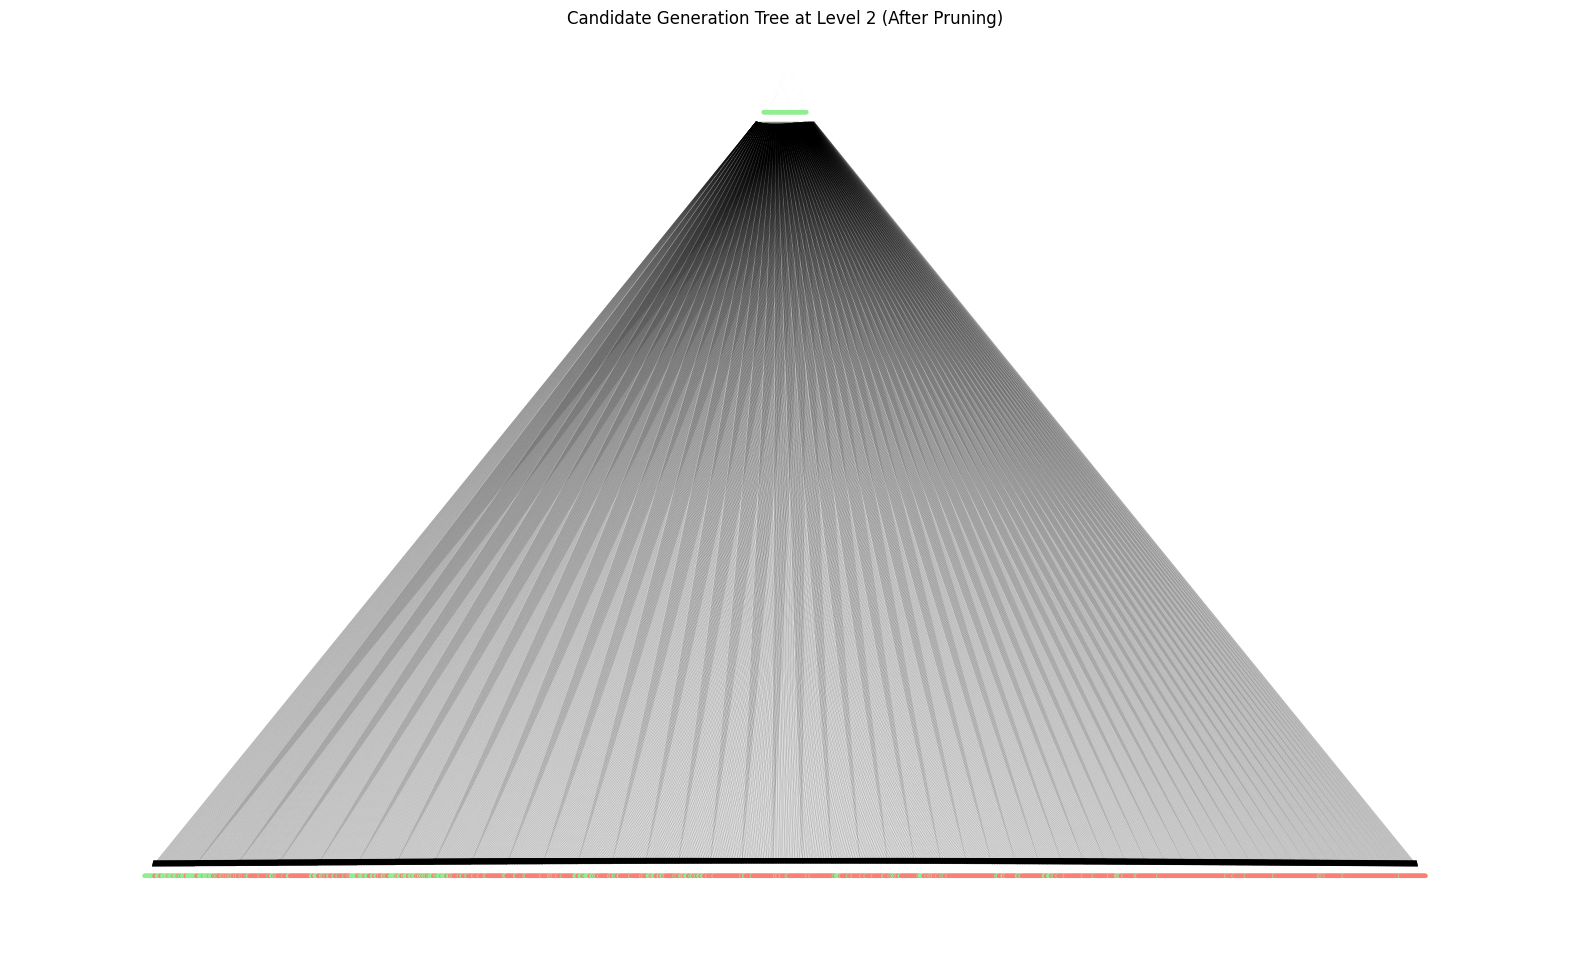

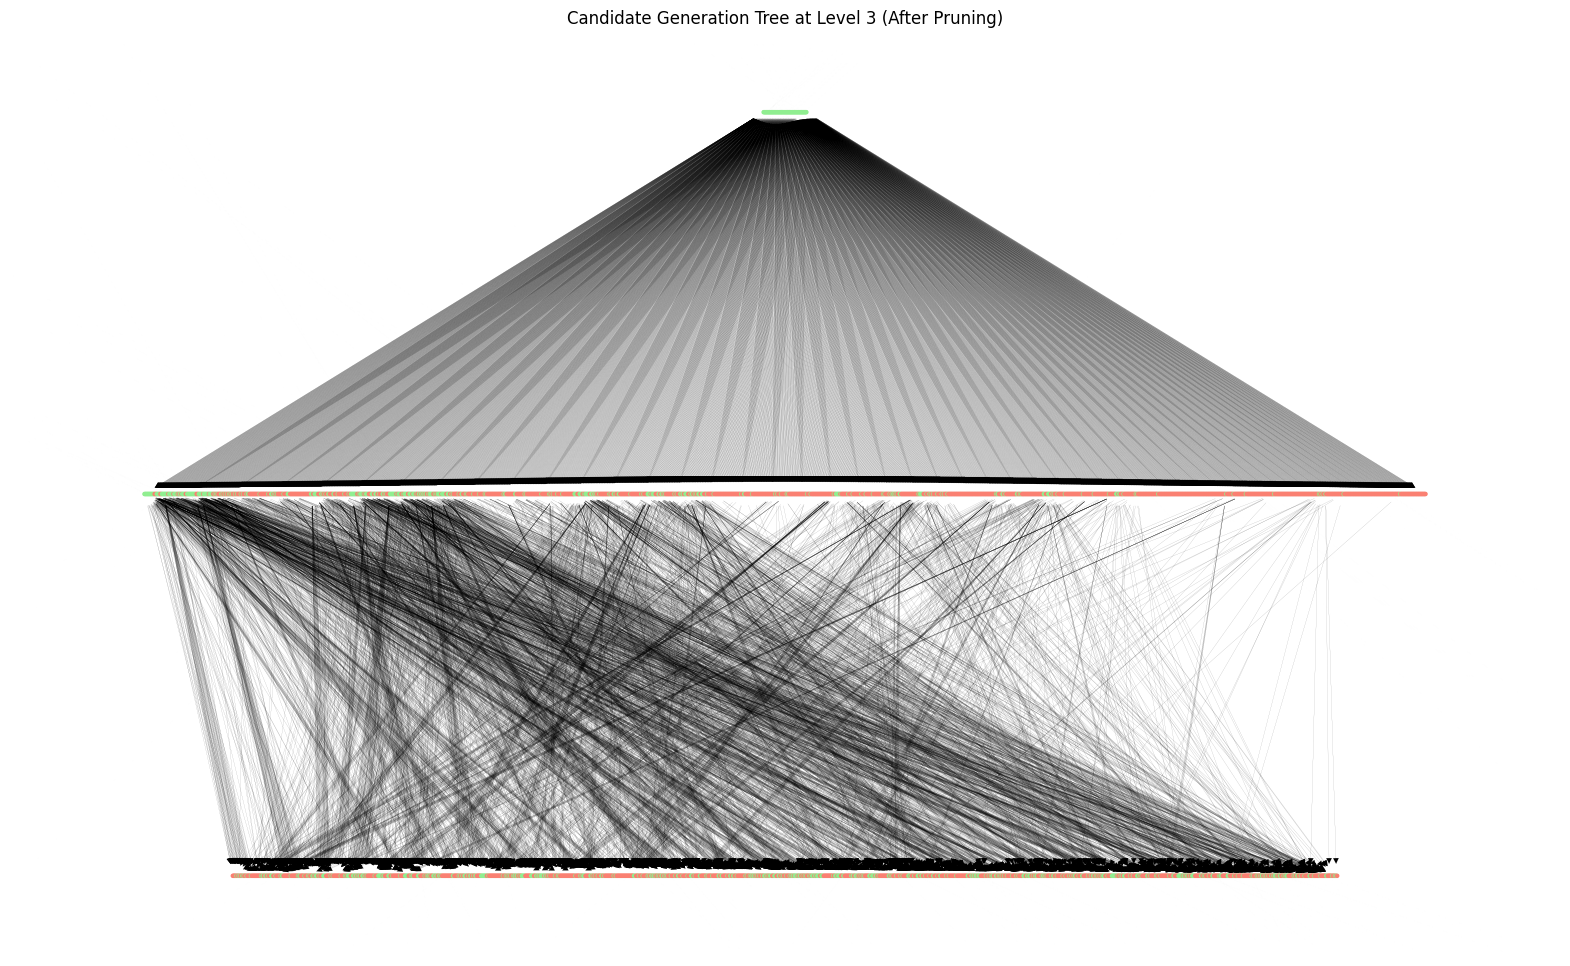

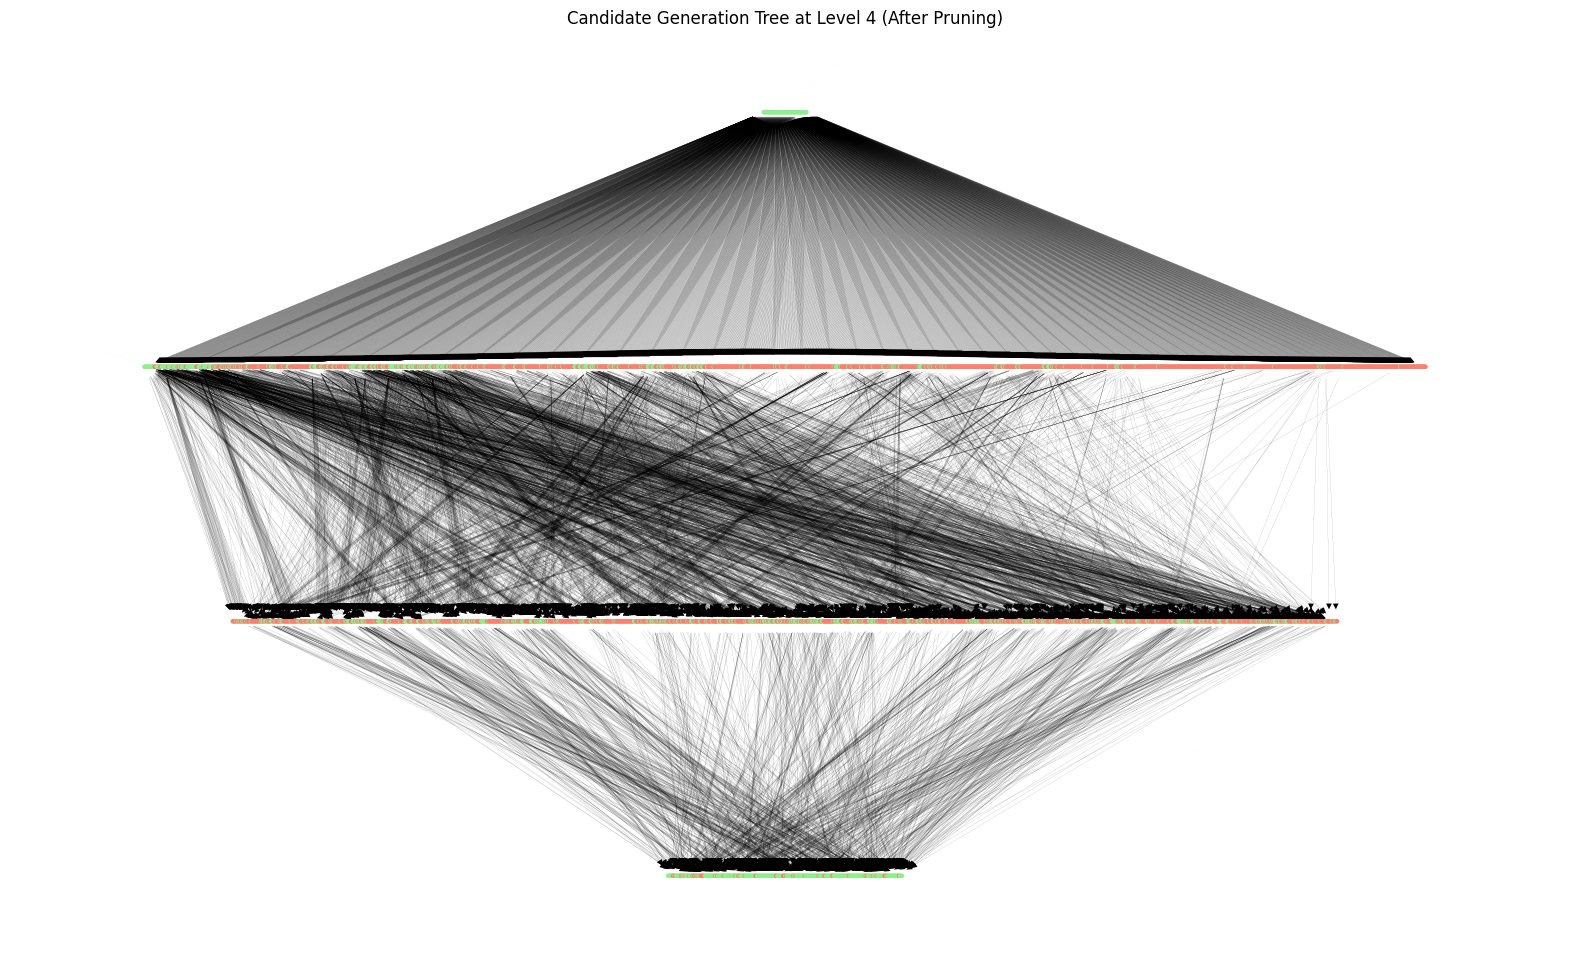

Number of frequent itemsets found: 1349

lhs rhs support
[1] {salad dressing} => {pastry, turkey} 0.000662691
[2] {pastry, turkey} => {salad dressing} 0.000662691
[3] {salad dressing} => {pip fruit, turkey} 0.000662691

confidence lift count
[1] 1.0000000 1509.00000 1
[2] 1.0000000 1509.00000 1
[3] 1.0000000 1509.00000 1


In [5]:
# Import required libraries
import csv
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------
# Utility: Plot Candidate Tree (Simplified)
# ---------------------------
def plot_tree(G, title):
    """
    Plot the candidate generation tree as small colored dots (no labels) and thin lines.
    Frequent nodes are light green; pruned nodes are salmon.
    """
    # Arrange nodes by their 'level' attribute.
    levels = nx.get_node_attributes(G, 'level')
    pos = {}
    level_nodes = {}
    for node, lvl in levels.items():
        level_nodes.setdefault(lvl, []).append(node)
    for lvl, nodes in level_nodes.items():
        n = len(nodes)
        for i, node in enumerate(nodes):
            pos[node] = (i - n/2, -lvl)
    
    # Set node colors based on their status.
    statuses = nx.get_node_attributes(G, 'status')
    node_colors = ['lightgreen' if statuses.get(node, 'frequent') == 'frequent' else 'salmon'
                   for node in G.nodes()]
    
    plt.figure(figsize=(20, 12))
    # Draw nodes as small dots (no labels)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=5)
    # Draw edges with very thin lines.
    nx.draw_networkx_edges(G, pos, width=0.05)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ---------------------------
# Apriori Algorithm Function
# ---------------------------
def apriori(transactions, min_support, plot_each_level=True):
    """
    Run the Apriori algorithm on a list of transactions.
    
    Parameters:
      transactions (list of lists): Each transaction is a list of items.
      min_support (int): The minimum absolute count an itemset must have to be considered frequent.
      plot_each_level (bool): If True, plot the candidate tree at levels where at least one node is pruned.
      
    Returns:
      freq_itemsets (dict): Keys are frozensets (frequent itemset) and values are support counts.
      G (networkx.DiGraph): The candidate generation tree (without node labels).
    """
    # Convert transactions to sets for faster membership tests.
    transactions = [set(t) for t in transactions]
    
    # --- Level 1: Generate candidate 1-itemsets (C1) ---
    C1 = {}
    for t in transactions:
        for item in t:
            candidate = frozenset([item])
            C1[candidate] = C1.get(candidate, 0) + 1
            
    # L1: Filter candidates with support >= min_support.
    L1 = {cand: count for cand, count in C1.items() if count >= min_support}
    freq_itemsets = {}
    G = nx.DiGraph()  # Graph to record candidate generation.
    
    level = 1
    # Add level-1 nodes (using empty labels).
    for candidate, support in L1.items():
        G.add_node(candidate, label="", level=level, support=support, status='frequent')
        freq_itemsets[candidate] = support
    
    # --- Generate candidates for levels k >= 2 ---
    current_L = L1
    while current_L:
        level += 1
        new_candidates = set()
        current_L_list = list(current_L.keys())
        
        # Join step: combine pairs of frequent itemsets.
        for i in range(len(current_L_list)):
            for j in range(i+1, len(current_L_list)):
                candidate = current_L_list[i] | current_L_list[j]
                if len(candidate) == level:
                    # Prune step: every (level-1)-subset must be frequent.
                    all_subsets_frequent = True
                    for subset in itertools.combinations(candidate, level - 1):
                        subset = frozenset(subset)
                        if subset not in current_L:
                            all_subsets_frequent = False
                            break
                    if all_subsets_frequent:
                        new_candidates.add(candidate)
                        # Connect candidate to its parent nodes.
                        G.add_edge(current_L_list[i], candidate)
                        G.add_edge(current_L_list[j], candidate)
        
        # Count support for each new candidate.
        Ck = {}
        for candidate in new_candidates:
            count = sum(1 for t in transactions if candidate.issubset(t))
            Ck[candidate] = count
            
        # Determine frequent itemsets (Lk) and mark pruned ones.
        Lk = {}
        for candidate, count in Ck.items():
            if count >= min_support:
                Lk[candidate] = count
                G.add_node(candidate, label="", level=level, support=count, status='frequent')
                freq_itemsets[candidate] = count
            else:
                G.add_node(candidate, label="", level=level, support=count, status='pruned')
        
        # Plot the candidate tree at this level only if any node was pruned.
        if plot_each_level:
            pruned_nodes = [n for n, data in G.nodes(data=True)
                            if data.get('level') == level and data.get('status') == 'pruned']
            if pruned_nodes:
                plot_tree(G, title=f"Candidate Generation Tree at Level {level} (After Pruning)")
                
        if not Lk:
            break  # Stop if no further frequent itemsets are found.
        current_L = Lk
        
    return freq_itemsets, G

# ---------------------------
# Association Rule Generation Function
# ---------------------------
def generate_association_rules(freq_itemsets, n_transactions):
    """
    Generate association rules from frequent itemsets.
    
    For every frequent itemset X (|X| >= 2) and every non-empty proper subset A ⊂ X,
    generate the rule A => (X \ A).
    
    Each rule includes:
      - lhs: the antecedent
      - rhs: the consequent
      - support: relative support of X (support(X)/n_transactions)
      - confidence: support(X) / support(A)
      - lift: confidence divided by the relative support of (X \ A)
      - count: absolute support count of X
    
    Returns:
      A list of dictionaries representing the rules.
    """
    rules = []
    for itemset, itemset_support in freq_itemsets.items():
        if len(itemset) < 2:
            continue
        # For every non-empty proper subset of the itemset:
        for i in range(1, len(itemset)):
            for subset in itertools.combinations(itemset, i):
                lhs = frozenset(subset)
                rhs = itemset - lhs
                if not rhs:
                    continue
                support_itemset = itemset_support
                support_relative = support_itemset / n_transactions
                support_lhs = freq_itemsets.get(lhs, 0)
                if support_lhs == 0:
                    continue
                confidence = support_itemset / support_lhs
                support_rhs = freq_itemsets.get(rhs, 0)
                if support_rhs == 0:
                    continue
                lift = confidence / (support_rhs / n_transactions)
                rules.append({
                    'lhs': lhs,
                    'rhs': rhs,
                    'support': support_relative,
                    'confidence': confidence,
                    'lift': lift,
                    'count': support_itemset
                })
    return rules

# ---------------------------
# Read and Filter the Groceries Dataset
# ---------------------------
transactions = []
csv_filename = "groceries.csv"  # Make sure this file is in your working directory.
with open(csv_filename, "r") as f:
    reader = csv.reader(f)
    for row in reader:
        # Each row is a list of items; remove extra whitespace.
        cleaned_items = [item.strip() for item in row if item.strip() != ""]
        if cleaned_items:
            transactions.append(cleaned_items)

print(f"Original number of transactions: {len(transactions)}")

# --- Halve the dataset by removing transactions that contain half of all items ---
# 1. Build a sorted list of all unique items.
all_items = set()
for t in transactions:
    all_items.update(t)
all_items = sorted(all_items)
print(f"Total unique items before filtering: {len(all_items)}")

# 2. Select half of the items (e.g., the first half in sorted order).
half_count = (len(all_items) // 2) + 20
items_to_remove = set(all_items[:half_count])
print(f"Removing transactions containing any of these {len(items_to_remove)} items: {items_to_remove}")

# 3. Remove any transaction that contains any item from items_to_remove.
filtered_transactions = [t for t in transactions if not any(item in items_to_remove for item in t)]
print(f"Number of transactions after filtering: {len(filtered_transactions)}")

# ---------------------------
# Run the Apriori Algorithm on the Filtered Dataset
# ---------------------------
# Set the minimum support threshold (absolute count). Adjust as needed.
min_support = 0.001
freq_itemsets, G = apriori(filtered_transactions, min_support, plot_each_level=True)
print(f"Number of frequent itemsets found: {len(freq_itemsets)}")

# ---------------------------
# Generate Association Rules and Format Output
# ---------------------------
n_transactions = len(filtered_transactions)
rules = generate_association_rules(freq_itemsets, n_transactions)

# Minimum confidence threshold. Adjust as needed.
min_confidence = 0.8
rules = [rule for rule in rules if rule['confidence'] >= min_confidence]

# Sort rules (for example, by lift in descending order)
rules_sorted = sorted(rules, key=lambda r: r['lift'], reverse=True)

# Print the top 3 rules in the specified format.
print("\nlhs rhs support")
for i, rule in enumerate(rules_sorted[:3], 1):
    lhs_str = "{" + ", ".join(sorted(rule['lhs'])) + "}"
    rhs_str = "{" + ", ".join(sorted(rule['rhs'])) + "}"
    # Print relative support with 9 decimal places.
    print(f"[{i}] {lhs_str} => {rhs_str} {rule['support']:.9f}")

print("\nconfidence lift count")
for i, rule in enumerate(rules_sorted[:3], 1):
    # Print confidence with 7 decimals and lift with 5 decimals.
    print(f"[{i}] {rule['confidence']:.7f} {rule['lift']:.5f} {rule['count']}")
